In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

____
## Basic Facts About the Data

The data set has simulated demographic information for users of a website. The primary information in the data set is whether or not each user clicked on an ad, represented by a boolean 0/1. The numerical data is:
* <b>Daily Time Spent on Site</b>: Time spent on the ficticious site in minutes
* <b>Age</b>: Age of the user in years
* <b>Area Income</b>: The average income of the user's geographical area, presumbaly in dollars
* <b>Daily Internet Usage</b>: Average daily internet access in minutes

In [2]:
ad_data = pd.read_csv('advertising.csv')

In [3]:
ad_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [4]:
ad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB


In [10]:
ad_data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


In [27]:
ad_data['Ad Topic Line'].nunique()

1000

There are 1000 unique ad lines served to users. That means each ad line in the table is unique.

In [28]:
ad_data['City'].nunique()

969

The users accessed the internet from 969 different cities. There are a relatively small number of repeats.

____
## Exploratory Data Analysis

Let's get a sense for the demographic breakdown of our data set. We'll start with the ages.

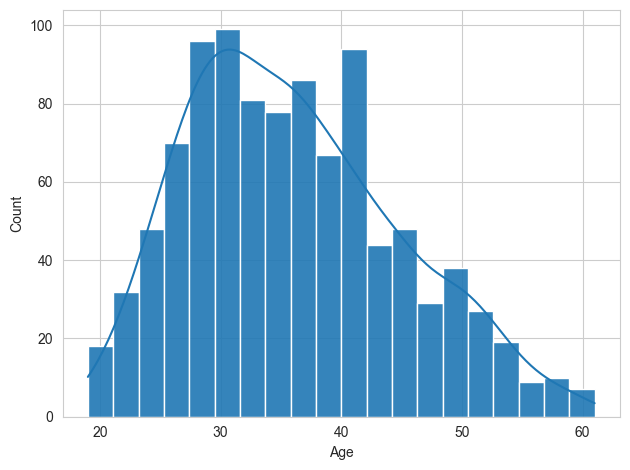

In [8]:
sns.histplot(data = ad_data, x='Age', bins=20, alpha=0.9, kde=True)
plt.tight_layout()

It doesn't look like this is normally distributed, but it could be lognormal, Rayleigh, gamma, etc.

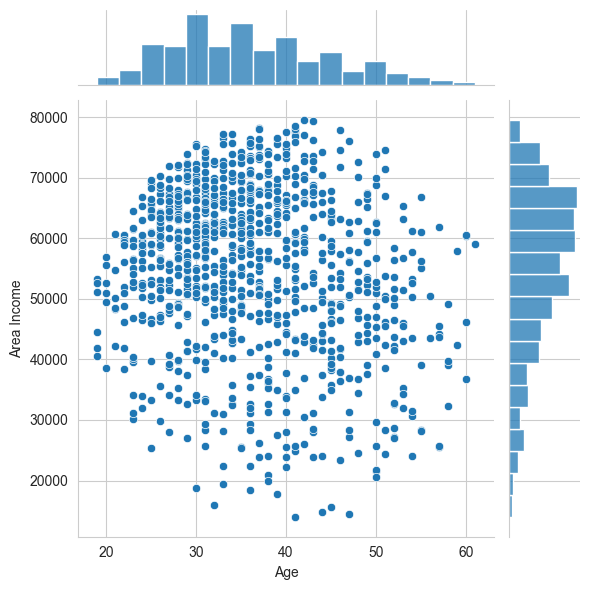

In [9]:
sns.jointplot(data = ad_data, x = 'Age', y = 'Area Income')
plt.tight_layout()

Based on this it doesn't look like the variables are particularly correlated, although there seems to be a rough negative correlation over all.

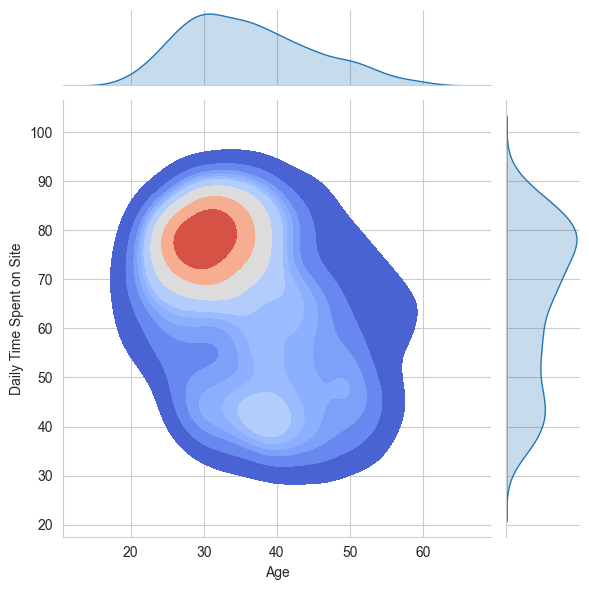

In [21]:
sns.jointplot(data = ad_data, x = 'Age', y = 'Daily Time Spent on Site', kind = 'kde', fill = True, cmap='coolwarm')
plt.tight_layout()

These two variables also do not look strongly correlated, but there is a rough negative correlation.

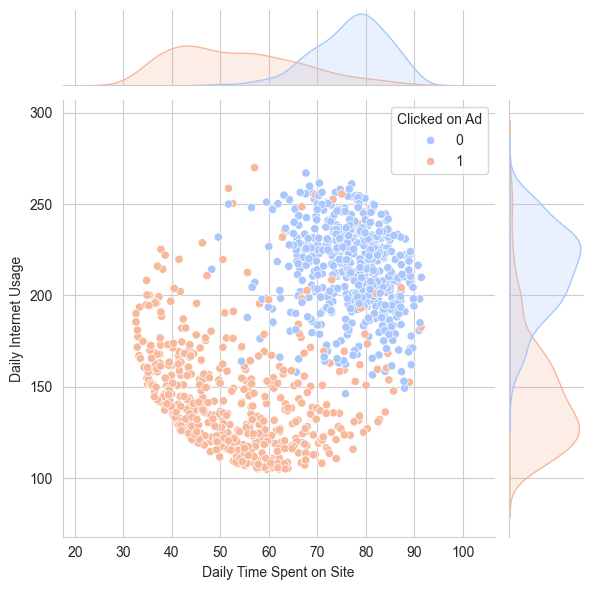

In [20]:
sns.jointplot(data = ad_data, x = 'Daily Time Spent on Site', y = 'Daily Internet Usage', hue='Clicked on Ad', palette='coolwarm')

The data here is strongly correlated and linearly separable, which bodes well for our upcoming regression analysis. We would expect that a user who spends a lot of time on the internet would also spend more time on the website. It's curious that users who spent less time on the site over all were more likely to click on the ad.

Let's get a general sense of how all of the other numerical variables interact with each other, and how the likelihood of clicking on an ad breaks down.

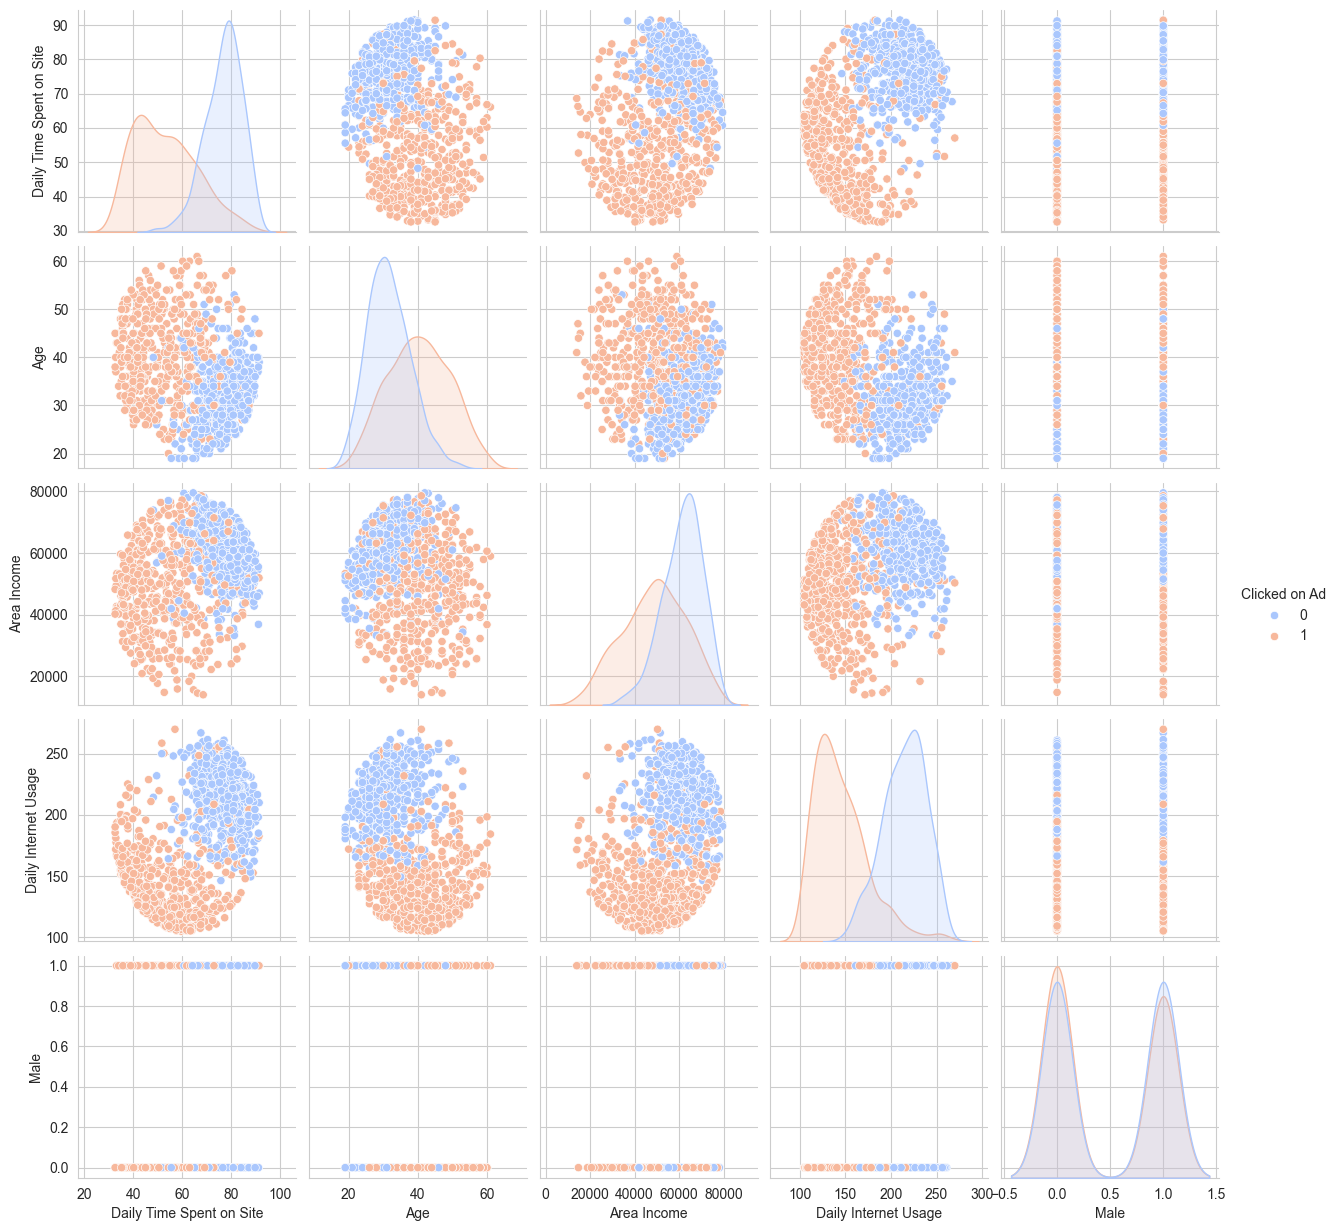

In [18]:
sns.pairplot(data = ad_data, hue = 'Clicked on Ad', palette='coolwarm')


In the daily time spent on site kde plot we see once again the counterintuitive splitting between who did or didn't click ont the ad. It is clear that users who spent a lot of time on the site were less likely to click the ad. The two most simple explanations for this are:
* the data was labelled in reverse (0 means they did click and 1 means they didn't), or
* long-duration users are more used to the site and/or more focused on the contents of the site and therefore less likely to be distracted by the ad

We find that older people are less likely to spend a long time on the site, but are more likely to click on the ad.

People in lower income areas are less likely to spend a long time on the site, and are more likely to click on the ad.

People who use the internet a lot are less likely to click on the add.

Men are less likely to click on the ad than women, though not by much. Gender does not have a significant impact on the likelihood of clicking the ad.

In [23]:
ad_data['Timestamp'] = pd.to_datetime(ad_data['Timestamp'])

In [24]:
ad_data['hour'] = ad_data['Timestamp'].apply(lambda ts: ts.hour)
ad_data['day of week'] = ad_data['Timestamp'].apply(lambda ts: ts.dayofweek)

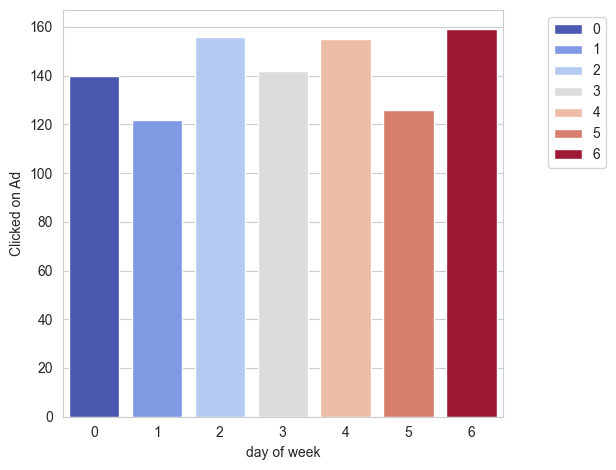

In [44]:
sns.barplot(ad_data.groupby('day of week').count(), y='Clicked on Ad', x='day of week',
            hue='day of week', palette='coolwarm', orient='v').legend(bbox_to_anchor=(1.25,1), loc='upper right')
plt.tight_layout()

The day of the week doesn't have a huge impact on how many people cliked on an ad.

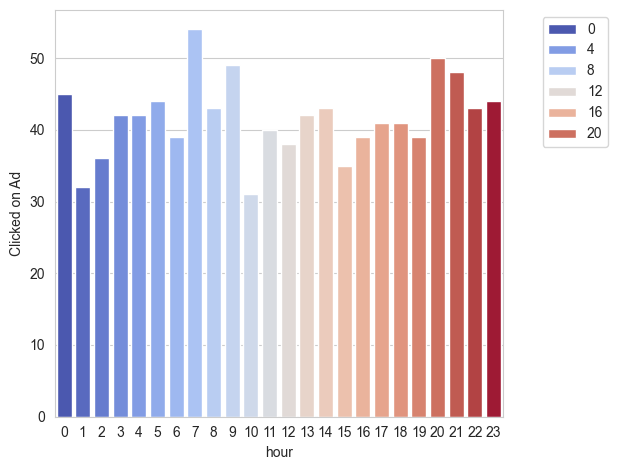

In [43]:
sns.barplot(ad_data.groupby('hour').count(), y='Clicked on Ad', x='hour',
            hue='hour', palette='coolwarm', orient='v').legend(bbox_to_anchor=(1.25,1), loc='upper right')
plt.tight_layout()

This seems to be almost bi-modal, with peaks in the morning and late at night. The most likely time for somebody to click on an ad is when they're browsing the site in the morning, perhaps while having breakfast before work.

Finally, let's take a closer look at the correlations between the numeric variables.

In [45]:
ad_data.corr(numeric_only=True)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,hour,day of week
Daily Time Spent on Site,1.000000,-0.331513,0.310954,0.518658,-0.018951,-0.748117,0.000895,0.018336
Age,-0.331513,1.000000,-0.182605,-0.367209,-0.021044,0.492531,-0.049905,0.013593
Area Income,0.310954,-0.182605,1.000000,0.337496,0.001322,-0.476255,0.034573,0.013879
Daily Internet Usage,0.518658,-0.367209,0.337496,1.000000,0.028012,-0.786539,0.074347,0.009035
Male,-0.018951,-0.021044,0.001322,0.028012,1.000000,-0.038027,0.058552,-0.038861
Clicked on Ad,-0.748117,0.492531,-0.476255,-0.786539,-0.038027,1.000000,-0.047431,0.002003
hour,0.000895,-0.049905,0.034573,0.074347,0.058552,-0.047431,1.000000,0.007034
day of week,0.018336,0.013593,0.013879,0.009035,-0.038861,0.002003,0.007034,1.000000


<Axes: >

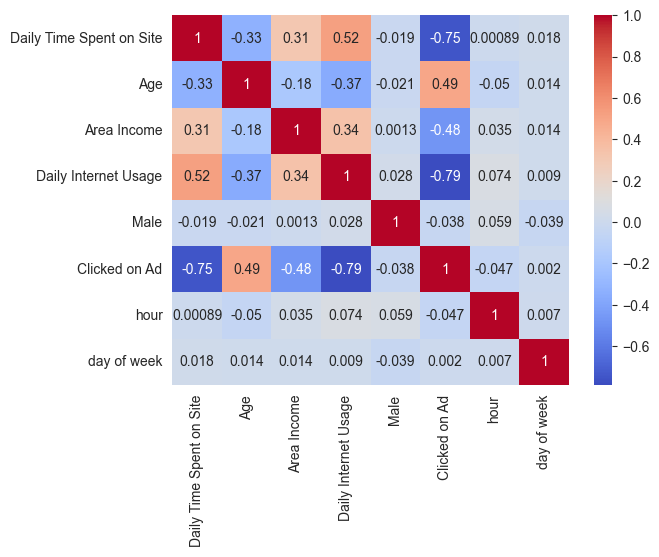

In [46]:
sns.heatmap(ad_data.corr(numeric_only=True), cmap='coolwarm', annot=True)

____
## Preparing Data For Regression

Let's train a simple model to predict whether or not an internet user will click on an ad served to them. There are too many cities and countries to realistically turn them all into categorical variables, so we're going to drop those columns. Moreover, we won't be doing any NLP, so we'll also drop the column with the ad topic. There isn't a noteworth correlation between time of day or day of week with clicking on the ad, so we're going to drop that information too.

In [47]:
ad_data.drop(['Ad Topic Line', 'City', 'Country', 'Timestamp', 'day of week', 'hour'], axis = 1, inplace = True)
numeric_vars = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male'
]

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [50]:
X_test, X_train, y_test, y_train = train_test_split(ad_data.drop('Clicked on Ad', axis = 1),
                                                    ad_data['Clicked on Ad'], test_size = 0.3, random_state = 101)

____
## Training the Model

In [51]:
logmodel_pipe = make_pipeline(StandardScaler(), LogisticRegression())
logmodel_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

We can view the coefficients of the model, which tell us the partial derivatives with respect to each input variable. This gives us a sense of how important each variable is to the model.

In [64]:
for var, coef in zip(numeric_vars, logmodel_pipe.named_steps['logisticregression'].coef_[0]):
        print(f'{var} Coefficient: ', coef)

Daily Time Spent on Site Coefficient:  -2.447542200177451
Age Coefficient:  1.5239866084891303
Area Income Coefficient:  -1.3893259500525272
Daily Internet Usage Coefficient:  -2.255893917570643
Male Coefficient:  0.03809243604669796


These track with what we saw in the plots and correlation table/heatmap earlier. The most important factor is the daily time spent on the site, and the least important factor is gender.

____
## Predictions and Evaluations

In [65]:
predictions = logmodel_pipe.predict(X_test)

Error analysis in logistic regression is conveniently done using a classification report and confusion matrix. 

In [66]:
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
print('Classification Report: \n', classification_report(y_test, predictions))

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       343
           1       0.98      0.95      0.96       357

    accuracy                           0.96       700
   macro avg       0.96      0.96      0.96       700
weighted avg       0.96      0.96      0.96       700



In [68]:
print('Confusion Matrix: \n', confusion_matrix(y_test, predictions))

Confusion Matrix: 
 [[336   7]
 [ 19 338]]


Our model is quite good at making predictions, which we can see from the scores in the classification report. The precision and recall for both categories is very high. The model is also very accurate, which is good.